# Cartpole
This code is based on [the cartpole example](https://github.com/stack-of-tasks/pinocchio/blob/master/examples/simulation-pendulum.py) provided by the [Pinocchio](https://stack-of-tasks.github.io/pinocchio/) library. The goal is to balance a pendulum in the upright position by moving the cart below.

The state of the system $x=[y\:\:\:\theta\:\:\:\dot{y}\:\:\:\dot{\theta}]$ is by the position of the cart $y$, the angle of the pendulum $\theta$, and their temporal derivatives. The control input $u$ is the force applied to the cart.

In [1]:
import math
import sys
import time
from matplotlib import pyplot as plt

import hppfcl as fcl
import numpy as np
import pinocchio as pin
from pinocchio.visualize import MeshcatVisualizer as Visualizer
import ilqr

In [2]:
Nb_pendulums = 1  # number of pendulums

model = pin.Model()
geom_model = pin.GeometryModel()

parent_id = 0

cart_radius = 0.1
cart_length = 5 * cart_radius
cart_mass = 2.0
joint_name = "joint_cart"

geometry_placement = pin.SE3.Identity()
geometry_placement.rotation = pin.Quaternion(
    np.array([0.0, 0.0, 1.0]), np.array([0.0, 1.0, 0.0])
).toRotationMatrix()

joint_id = model.addJoint(
    parent_id, pin.JointModelPY(), pin.SE3.Identity(), joint_name
)

body_inertia = pin.Inertia.FromCylinder(cart_mass, cart_radius, cart_length)
body_placement = geometry_placement
# We need to rotate the inertia as it is expressed in the LOCAL frame of the
# geometry.
model.appendBodyToJoint(joint_id, body_inertia, body_placement)

shape_cart = fcl.Cylinder(cart_radius, cart_length)

geom_cart = pin.GeometryObject(
    "shape_cart", joint_id, geometry_placement, shape_cart
)
geom_cart.meshColor = np.array([1.0, 0.1, 0.1, 1.0])
geom_model.addGeometryObject(geom_cart)

parent_id = joint_id

joint_placement = pin.SE3.Identity()
body_mass = 1.0
body_radius = 0.1

for k in range(Nb_pendulums):
    joint_name = "joint_" + str(k + 1)
    joint_id = model.addJoint(
        parent_id, pin.JointModelRX(), joint_placement, joint_name
    )

    body_inertia = pin.Inertia.FromSphere(body_mass, body_radius)
    body_placement = joint_placement.copy()
    body_placement.translation[2] = 1.0
    model.appendBodyToJoint(joint_id, body_inertia, body_placement)

    geom1_name = "ball_" + str(k + 1)
    shape1 = fcl.Sphere(body_radius)
    geom1_obj = pin.GeometryObject(geom1_name, joint_id, body_placement, shape1)
    geom1_obj.meshColor = np.ones(4)
    geom_model.addGeometryObject(geom1_obj)

    geom2_name = "bar_" + str(k + 1)
    shape2 = fcl.Cylinder(body_radius / 4.0, body_placement.translation[2])
    shape2_placement = body_placement.copy()
    shape2_placement.translation[2] /= 2.0

    geom2_obj = pin.GeometryObject(geom2_name, joint_id, shape2_placement, shape2)
    geom2_obj.meshColor = np.array([0.0, 0.0, 0.0, 1.0])
    geom_model.addGeometryObject(geom2_obj)

    parent_id = joint_id
    joint_placement = body_placement.copy()

In [3]:
visual_model = geom_model
# Initialize the viewer.
try:
    viz = Visualizer(model, geom_model, visual_model)
    viz.initViewer()
except ImportError as err:
    print(
        "Error while initializing the viewer. "
        "It seems you should install gepetto-viewer"
    )
    print(err)
    sys.exit(0)

try:
    viz.loadViewerModel("pinocchio")
except AttributeError as err:
    print(
        "Error while loading the viewer model. "
        "It seems you should start gepetto-viewer"
    )
    print(err)
    sys.exit(0)

# Display a robot configuration.
q0 = pin.neutral(model)
viz.display(q0)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [4]:
dt = 0.01
T = 5
N = math.floor(T / dt)

model.lowerPositionLimit.fill(-math.pi)
model.upperPositionLimit.fill(+math.pi)
model.lowerPositionLimit[0] = model.upperPositionLimit[0] = 0.0

data_sim = model.createData()

# q = pin.randomConfiguration(model)
q = np.array(np.array([0.0] + [np.pi] * Nb_pendulums))
v = np.zeros(model.nv)

def dynamics(x, u):
    q, v = x[:model.nq], x[model.nq:]

    # apply the ABA algorithm to compute the acceleration
    a = pin.aba(model, data_sim, q, v, u)

    # integrate the acceleration to get the new state
    v += a * dt
    q = pin.integrate(model, q, v * dt)

    return np.concat((q, v))


def compute_jac(x, u):
    q, v = x[:model.nq], x[model.nq:]

    a = pin.aba(model, data_sim, q, v, u)
    new_v = v + a * dt

    J1_q, J1_v, J1_u = pin.computeABADerivatives(model, data_sim, q, v, u)
    J2_q, J2_v_prim = pin.dIntegrate(model, q, new_v * dt)

    dnew_v_dq = J1_q * dt
    dnew_v_dv = np.eye(model.nv) + J1_v * dt
    dnew_v_du = J1_u * dt

    dnew_q_dq = J2_q + J2_v_prim @ dnew_v_dq * dt
    dnew_q_dv = J2_v_prim @ dnew_v_dv * dt
    dnew_q_du = J2_v_prim @ dnew_v_du * dt

    jac_x = np.block([[dnew_q_dq, dnew_q_dv], [dnew_v_dq, dnew_v_dv]])
    jac_u = np.vstack((dnew_q_du, dnew_v_du))

    return jac_x, jac_u

state_dim = model.nq + model.nv
control_dim = model.nq

Q = np.zeros((state_dim, state_dim)) # state cost
Qf = np.diag([1, 1e5, 1e1, 2e-1]) # final state cost
R = 1e-5 * np.eye(control_dim) # control cost (minimize the energy)

s = ilqr.ILQRSolver(state_dim, control_dim, Q, Qf, R)

target = np.zeros(state_dim) # target state, upright pendulum with no velocity
output = s.solve(np.concatenate((q, v)), target, dynamics, time_steps=N, jacobians=compute_jac,
                 max_iterations=100, initialization=0.01, cost_threshold=0.1, gradient_clip=50.0, full_output=True)

print(f"Solution Kind: {output['kind']}")
print(f"Time Taken: {output['time_taken']}")
print(f"Iteration Needed: {output['it_taken']}")

Solution Kind: converged
Time Taken: 0.452360795
Iteration Needed: 22


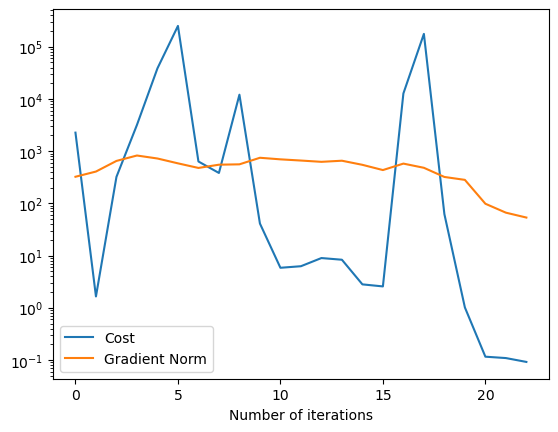

In [5]:
nb_it = len(output['cost'])

plt.semilogy(np.arange(nb_it), output['cost'], label='Cost')
plt.semilogy(np.arange(nb_it), output['gradient_norm'], label='Gradient Norm')
plt.legend()
plt.xlabel("Number of iterations")
plt.show()

In [6]:
t = 0.0
q = np.array(np.array([0.0] + [np.pi] * Nb_pendulums))
v = np.zeros(model.nv)

viz.display(q)

for k in range(N):
    tic = time.time()

    tau_control = output['control'][k]
    x = dynamics(np.concat((q, v)), tau_control)
    q, v = x[:model.nq], x[model.nq:]

    viz.display(q)

    toc = time.time()
    elapsed = toc - tic
    dt_sleep = max(0, dt - elapsed)

    time.sleep(dt_sleep)
    t += dt

In [7]:
print(f"Final q: {q}")
print(f"Target q: {target[:model.nq]}")
print()
print(f"Final v: {v}")
print(f"Target v: {target[model.nq:]}")
print()
print(f"Error: {np.linalg.norm(target - x):.5f}")

Final q: [1.47210642e-02 1.61460053e-07]
Target q: [0. 0.]

Final v: [-0.00018683 -0.02173338]
Target v: [0. 0.]

Error: 0.02625


In [8]:
NB_REP = 10
cost_thresh = 0.1
gradient_clip = 50
max_it = 40
init = 0.01

q = np.array(np.array([0.0] + [np.pi] * Nb_pendulums))
v = np.zeros(model.nv)
x0 = np.concatenate((q, v))
target = np.zeros(state_dim)

In [9]:

tps_with_jac = []
jac_tps_with_jac = []
it_with_jac = []
while len(tps_with_jac) < NB_REP:
    try:
        output = s.solve(x0, target, dynamics, time_steps=N, jacobians=compute_jac,
                         max_iterations=max_it, initialization=init, cost_threshold=cost_thresh,
                         gradient_clip=gradient_clip, full_output=True)

        if output['kind'] == 'converged':
            tps_with_jac.append(output['time_taken'])
            it_with_jac.append(output['it_taken'])
            jac_tps_with_jac.extend(output['jac_time_taken'])
            print(f"{len(tps_with_jac)}/{NB_REP}")
    except:
        print("Retrying...")
tps_with_jac = np.asarray(tps_with_jac)
jac_tps_with_jac = np.asarray(jac_tps_with_jac)
it_with_jac = np.asarray(it_with_jac)

tps_without = []
jac_tps_without = []
it_without = []
while len(tps_without) < NB_REP:
    try:
        output = s.solve(x0, target, dynamics, time_steps=N,
                         max_iterations=max_it, initialization=init, cost_threshold=cost_thresh,
                         gradient_clip=gradient_clip, full_output=True)

        if output['kind'] == 'converged':
            tps_without.append(output['time_taken'])
            it_without.append(output['it_taken'])
            jac_tps_without.extend(output['jac_time_taken'])
            print(f"{len(tps_without)}/{NB_REP}")
    except:
        print("Retrying...")
tps_without = np.asarray(tps_without)
jac_tps_without = np.asarray(jac_tps_without)
it_without = np.asarray(it_without)

1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
10/10
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
10/10


In [11]:
print("With jacobian callback:")
print(f"Iterations: {it_with_jac.mean():.4} it (std: {it_with_jac.std():.4} it)")
print(f"Time: {tps_with_jac.mean():.4} sec (std: {tps_with_jac.std():.4} sec)")
print(f"Jacobian Time: {jac_tps_with_jac.mean():.4} sec (std: {jac_tps_with_jac.std():.4} sec)")
print()
print("Without callback:")
print(f"Iterations: {it_without.mean():.4} it (std: {it_without.std():.4} it)")
print(f"Time: {tps_without.mean():.4} sec (std: {tps_without.std():.4} sec)")
print(f"Jacobian Time: {jac_tps_without.mean():.4} sec (std: {jac_tps_without.std():.4} sec)")

With jacobian callback:
Iterations: 21.2 it (std: 7.264 it)
Time: 0.3947 sec (std: 0.1351 sec)
Jacobian Time: 2.621e-05 sec (std: 1.424e-06 sec)

Without callback:
Iterations: 21.9 it (std: 3.727 it)
Time: 0.5911 sec (std: 0.0973 sec)
Jacobian Time: 4.311e-05 sec (std: 4.064e-06 sec)
